Import neccessary extensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy
import scipy.optimize as scpo 

Define constants and x values

In [2]:
Iterations = (10**5)
N = 7
T = N
#epsilon = T/(N)
m = 1
hbar = 1

xf = 3
xi = -3

dx = 0.05
dt = T/N
_dt = N/T

xs = np.arange(xi,dx-xi,dx)
#A = (m/(2*np.pi*dt))**(0.5*N)
#print("xs =", xs)

Functions

In [3]:
def wavefunc(x):
    return (np.exp(-0.5*x**2)/np.pi**0.25)**2

def potential(x):
    return 0.5*(x**2)

def kinetic(v):
    return 0.5*m*(v**2)

def S(path):
    E = 0
    for i in range(1,N):
        E += S_j(path,i)
    return E

def S_j(path,i):
    return dt*(kinetic((path[i]-path[i-1])*_dt) + potential(0.5*(path[i]+path[i-1])))

def metropolis(numberOfPaths,x): #iterates num times to generate optimized paths that start and end at a given x

    thermalInterval = 10

    array = np.zeros(shape=(numberOfPaths,N))
    initialPath = np.ones(N)*5
    #np.random.uniform(-3,3,N) # generate random path
    initialPath[0] = initialPath[-1] = x # set starting points to x

    #seeding the algorithm should take place here
    #goal is to perform thermalizations until the path acceptance rate is between 40-60%
    #an optimised path is generated after around 20-40 sweeps based on several trials

    #ac = rj = t = 0
    #actionarray = np.zeros(100)
    for seed in range(1,41):
        perturbedPath = initialPath
        # The following loop is equivalent to one thermalization sweep
        for i in range(1,N-1):
            old = perturbedPath[i]
            a = S_j(perturbedPath,i)+S_j(perturbedPath,i+1) #Finds the change in action at x_j
            perturbedPath[i] += np.random.uniform(-1,1)
            b = S_j(perturbedPath,i)+S_j(perturbedPath,i+1)
            actiondiff = (b-a)

            if actiondiff < 0 or np.random.uniform(0,1) < np.exp(-actiondiff):
                #ac += 1
                initialPath[i] = perturbedPath[i]

            else:
                #rj += 1
                perturbedPath[i] = old

        #t+=100*ac/(ac+rj)
        #print(t/u, u)
        #ac = rj =0
        #actionarray[u-1] = S(perturbedPath)
    #print(np.std(actionarray))


    #metropolis starts here using the seeded path

    j = 0
    k = 0
    while j < numberOfPaths:

        perturbedPath = initialPath

        # The following loop is equivalent to one thermalization sweep
        for i in range(1,N-1):
            old = perturbedPath[i]
            a = S_j(perturbedPath,i)+S_j(perturbedPath,i+1) #Finds the change in action at x_j
            perturbedPath[i] += np.random.uniform(-1,1)
            b = S_j(perturbedPath,i)+S_j(perturbedPath,i+1)
            actiondiff = (b-a)

            if actiondiff < 0 or np.random.uniform(0,1) < np.exp(-actiondiff): initialPath[i] = perturbedPath[i]
            else: perturbedPath[i] = old
        
        k += 1
        if k == thermalInterval:
            array[j] = perturbedPath
            j+=1
            k = 0

    return array

def generateNRandomPaths(numberOfPaths,x):
    array = np.zeros(shape=(numberOfPaths,N))
    for j in range(0,numberOfPaths):
        initialPath = np.random.uniform(-xi,xi,N)
        initialPath[0] = initialPath[-1] = x
        array[j] = initialPath
    return array

def G(paths):#sums action of all paths
    #paths is a 2d array containing all paths
    num = len(paths)
    pathSum = 0
    for i in range(num):
        pathSum += np.exp(-S(paths[i]))
        
    return pathSum

metro = True

def Psi(num):
    array1 = np.zeros(len(xs))
    sum = 0
    for i in range(len(xs)):

        array1[i] = G(metropolis(num,xs[i])) #metropolis paths

        sum += array1[i]
        #print(xs[i])
    return array1/(sum*dx)

def average(num_to_avs,paths1):
    l = len(xs)
    array = np.zeros(shape=(num_to_avs,l))
    ave = np.zeros(l)
    errs = np.zeros(l)

    #print(array)
    for i in range(num_to_avs):
        array[i] = Psi(paths1)
        ave += array[i]
        #print(i)

    for k in range(l):
        errs[k] = np.std(array[:,k])

    averageys = ave/num_to_avs
    aveerrs = errs/np.sqrt(num_to_avs)



    return averageys, aveerrs

Execute the metropolis algorithm to generate a set of y values and errors

In [ ]:
ys, yerrs = average(100,500)

This Calculates the Chi squared curve values

In [ ]:
x_values = xs
y_values = ys
y_errors = yerrs

print(y_values)
print(y_errors)

def chifit(x,*params):#Model Function we are trying to fit to the data
    return (np.exp(-params[0]*x**2)/params[1])**2

initial_values = np.array([0.5, np.pi**0.25]) # Initial guess for fit parameters (The values of the true ground state wavefunction)
print(np.pi**0.25)

popt, cov = scpo.curve_fit(chifit, # function to fit
                                     x_values, # x data
                                     y_values, # y data
                                     sigma=y_errors, # array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial_values, # starting point for fit
                                     check_finite=True) # raise ValueError if NaN encountered (don't allow errors to pass)

##################################

def chi_squared(model_params, model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data, *model_params))/y_err)**2) # Note the `*model_params' here!

chi_squared_min = chi_squared(popt, chifit, x_values, y_values, y_errors)
print('chi^2_min = {}'.format(chi_squared_min))

degrees_of_freedom = x_values.size - popt.size
print(degrees_of_freedom)
print('reduced chi^2 = {}'.format(chi_squared_min/degrees_of_freedom))
print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))

popt_errs = np.sqrt(np.diag(cov))

for i, (val, err) in enumerate(zip(popt, popt_errs)):
    print('optimised parameter[{}] = ({} +/- {}) units'.format(i, val, err))


1.3313353638003897
chi^2_min = 208.69623789054802
119
reduced chi^2 = 1.7537498982398994
P(chi^2_min, DoF) = 7.146361537371984e-07
optimised parameter[0] = (0.502824237791883 +/- 0.0021148109712121003) units
optimised parameter[1] = (1.3493231248477913 +/- 0.011226580688601632) units


Plotting figures

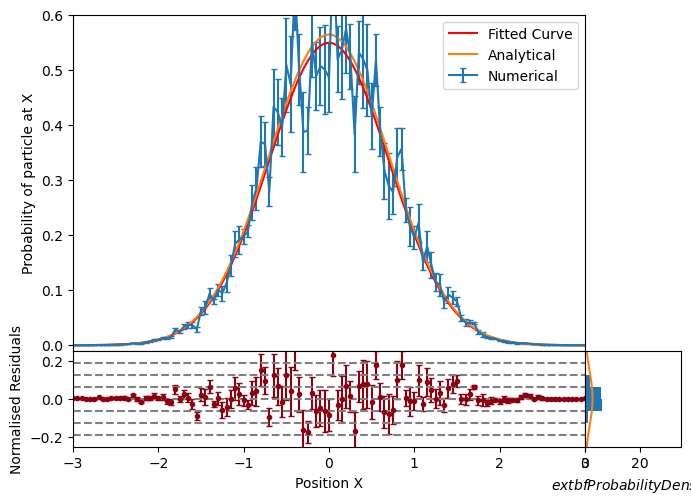

In [ ]:
#moi = generateNRandomPaths(1,0)[0]
#time = np.arange(0,T,dt)/dt
#plt.plot(moi,time)

f1 = plt.figure(1)
f1.add_axes((0,0,0.8,0.7))
plt.gca().set_ylim([-0.01,0.6])
plt.gca().set_xlim([-3,3])
plt.gca().axes.get_xaxis().set_ticks([])
plt.ylabel("Probability of particle at X")
#plt.plot(xs,Psi(paths))


chiValues = chifit(xs , *popt)
analyticalValues = wavefunc(xs)

normres = (ys-chiValues)/np.sqrt(chiValues)
reserrs = yerrs/np.sqrt(chiValues)


plt.errorbar(xs, ys, yerrs, capsize=2, label = "Numerical")#Plot the data

plt.plot(xs, chifit(xs , *popt), color='r', label = "Fitted Curve")#Plot the fitted curve

plt.plot(xs,wavefunc(xs), label = "Analytical")#plot the actual solution
plt.legend()

##########################################

j = 4

stdd = np.std(normres)

f1.add_axes((0,-0.2,0.8,0.2))
plt.gca().set_ylim([-j*stdd,j*stdd])
plt.gca().set_xlim([-3,3])


plt.ylabel("Normalised Residuals")
plt.xlabel("Position X")
stdresarray = np.ones(len(normres))*stdd
plt.errorbar( xs, normres, reserrs, fmt=".", color = "#8C000F", capsize=2)

for i in range(-j+1,j):
    plt.plot(xs,i*stdresarray, color='grey', linestyle='dashed')

#######################################

f1.add_axes((0.8,-0.2,0.15,0.2))
plt.gca().set_ylim([-j*stdd,j*stdd])
plt.gca().set_xlim([0,35])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xlabel("$\textbf{Probability Density}$")
histrange = np.arange(-j*stdd,(j+1)*stdd,stdd)

plt.hist(normres, histrange, density=1, orientation = "horizontal")
#f1.add_axes((0.8,-0.4,0.15,0.2))
x = np.arange(-j*stdd,j*stdd,0.0000001)
mean = statistics.mean(x)
sd = statistics.stdev(x)
plt.plot( norm.pdf(x, mean, sd), x)

# np.arange(-j*stdd,(j+1)*stdd,0.5*stdd)


#actionarray = metropolis(100,0)
#plt.plot(np.arange(0,100,1),actionarray)
plt.show()